In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import scipy
from Bio import Phylo
import matplotlib.pyplot as plt


In [8]:

def distance_matrix (path_to_tree_nwk):
    """Create a dataframe (like a matrix) containig distances between all species"""
    tree = Phylo.read(path_to_tree_nwk, format='newick')
    taxa = []
    for term in tree.get_terminals():   #select only terminal nodes
        taxa.append(term.name)  #get the name of the taxa
    distance_df = pd.DataFrame(index = taxa, columns=taxa)
    for i in taxa: 
        for j in taxa : 
            distance_df.loc[i][j]=tree.distance(i,j)
    distance_df= distance_df.astype(float)
    return distance_df

def get_order (distance_df):
    species_order = distance_df.index.to_list()     #create a list with species in a fixed order to use for the other heatmaps
    species_order[10] ='Saimiri_boliviensis_boliviensis'    #change the name used by TimeTree for the one I use
    species_order = [name.replace('_', ' ') for name in species_order]
    return species_order

def create_ks_df (table_species, path_to_genomes_df_dir,data_column, pvalue_or_statistic, species_order, path_to_matrix) : 
    """Create a ks_score matrix in a dataframe"""
    df_table= pd.read_csv(table_species)
    genid_species = dict(zip(df_table['genome_id'], df_table['species_name']))  #dictionary containing tuples (genome_id/specie_name)
    genomes_list = []
    species_list = []
    df=[]
    for genome in os.scandir(path_to_genomes_df_dir): 
        genomes_list.append(genome.name)
        species_list.append(genid_species.get(genome.name))
    for i in range(len(genomes_list)): 
        path_dir= os.path.join(path_to_genomes_df_dir,genomes_list[i])  #write path to the dataframe
        df_stats_i = pd.read_csv(os.path.join(path_dir,'df_stats'))
        row = []
        for j in range(len(genomes_list)):
            path_dir= os.path.join(path_to_genomes_df_dir,genomes_list[j])
            df_stats_j = pd.read_csv(os.path.join(path_dir,'df_stats'))
            ks_score = scipy.stats.ks_2samp(df_stats_i[data_column], df_stats_j[data_column],nan_policy='omit')
            if pvalue_or_statistic == 'pvalue':
                row.append(ks_score.pvalue)
            elif pvalue_or_statistic == 'statistic':
                row.append(ks_score.statistic)
        df.append(row)
    df_ks = pd.DataFrame(df, columns=species_list, index=species_list)
    df_ks = df_ks.reindex(index=species_order, columns=species_order)   #keep the order the same as the tree one
    df_ks.to_csv(path_to_matrix)
    return df_ks

def half_headmap (df_ks, distance_df, path_to_heatmap, title):
    #masks hide half of the heatmap
    mask1 = np.tril(np.ones_like(df_ks, dtype=bool))
    mask2 = np.triu(np.ones_like(distance_df, dtype=bool))
    #heatmap half distances, half statistics of number of introns, half distances
    fig, ax = plt.subplots(figsize=(12, 7))  #create the figure
    cmap_reversed = plt.colormaps['rocket'].reversed()
    sns.heatmap(df_ks, mask=mask1, cmap=cmap_reversed, vmax=.2, xticklabels=True, yticklabels=True, cbar_kws={'label': 'KS statistics'})
    sns.heatmap(distance_df, mask=mask2, cmap='grey', xticklabels=True, yticklabels=True, cbar_kws={'label': 'Phylogenetic Distances (Myr)'})
    ax.set(xlabel="Species", ylabel="Species")
    ax.set_title(title)
    ax.set_xticklabels([label.get_text().replace('_', ' ') for label in ax.get_yticklabels()], fontstyle='italic')
    ax.set_yticklabels([label.get_text().replace('_', ' ') for label in ax.get_yticklabels()], fontstyle='italic')
    plt.tight_layout()
    plt.savefig(path_to_heatmap, bbox_inches='tight')

distance_df = distance_matrix('/home/collot/stage_git/species_tree.nwk')


/tmp/ipykernel_3515910/165966206.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  distance_df.loc[i][j]=tree.distance(i,j)


In [3]:
species_order = get_order(distance_df)


In [4]:
df_ks = create_ks_df('/home/collot/stage_git/table_species.csv','/home/collot/stage/collot/collot/out_stats/output_dataframes', data_column="nb_introns" , pvalue_or_statistic="statistic", species_order=species_order, path_to_matrix='/home/collot/stage/collot/collot/out_stats/matrix_introns_number.csv')


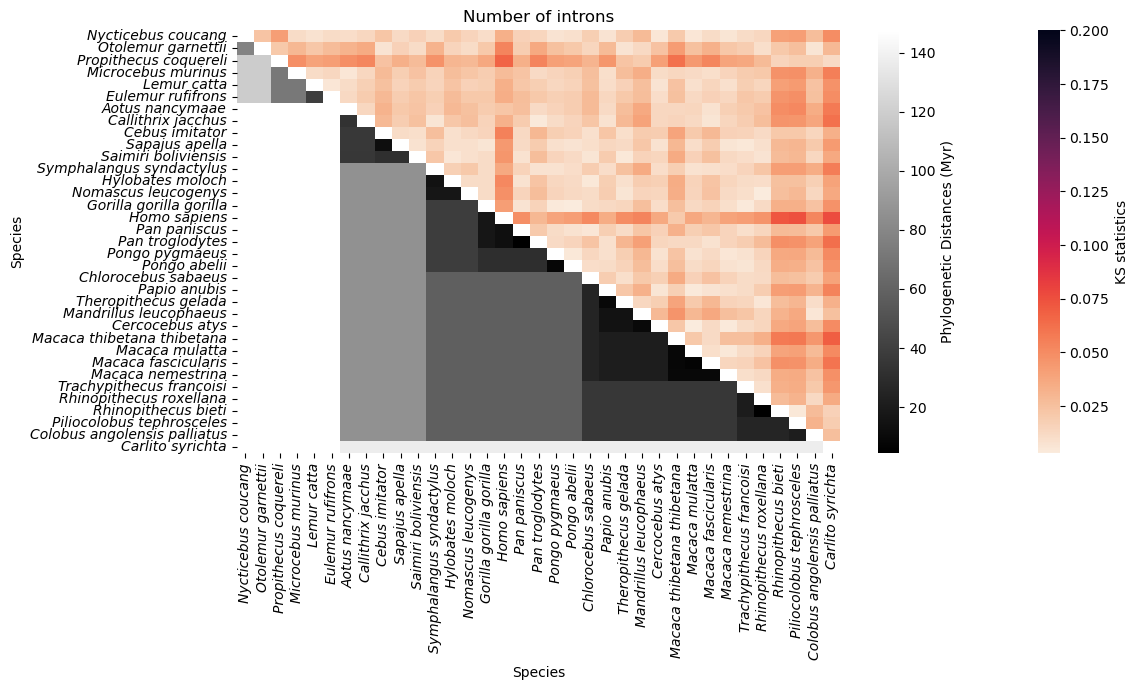

In [9]:
half_headmap(df_ks, distance_df, '/home/collot/stage_git/figures/heatmap_introns_number.png', title='Number of introns')

